# Problema 2: Modelos de Regresión

Primero para ello se vuelve a cargar las librerias necesarias

In [1]:
import xarray as xr
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns
from funciones_aux import load_n_combine_df
from funciones_aux import load_n_combine_mod_df

#Modelos:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
import xgboost as xgb

#stacking:
from sklearn.ensemble import StackingRegressor

#Hiperparametros
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import pickle
import joblib

# from lwoku import RANDOM_STATE, N_JOBS, VERBOSE, get_prediction
VERBOSE = 0
from grid_search_utils import plot_grid_search, table_grid_search

#Metricas:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

#Escalado
from sklearn.preprocessing import StandardScaler


## Ejemplo de algoritmo de Regresión:

Ahora se seleccionan los splits de datos para entrenamiento, validación y test.

In [3]:
(X_train,y_train),(X_validate,y_validate),(X_test,y_test) = load_n_combine_df(features_to_keep=np.arange(0,36,1),class_labels=False,dropzeros=False)

Observemos que contiene los datos de y_train:

In [3]:
y_train

array([ 0,  0,  0, ..., 40, 35, 57], shape=(353738,))

Esta al usar class_label=False nos devuelve el número de rayos contenido en la imagen, de forma más visual:

Text(0.5, 1.0, 'Grafica del numero de imagenes con x cantidad de rayos')

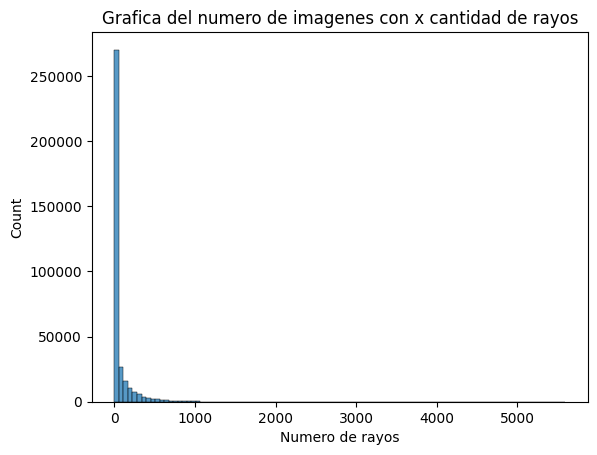

In [4]:
sns.histplot(y_train, bins=100)
plt.xlabel('Numero de rayos')
plt.title('Grafica del numero de imagenes con x cantidad de rayos')

Si se realiza el plot del numero de rayos como la funcion de la minima temperatura del brillo, se ve que es muy dificil ajustar un modelo lineal a estos datos

Text(0, 0.5, 'Numero de rayos')

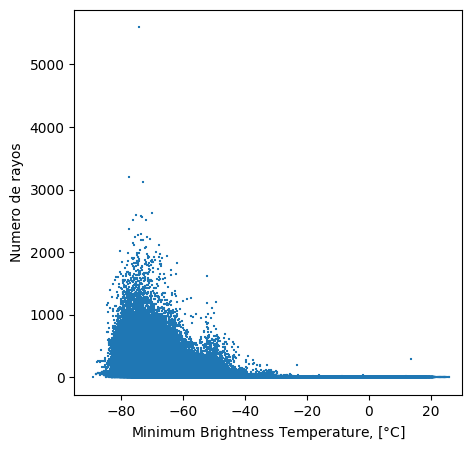

In [5]:
#Dimension de la figura
fig = plt.figure(figsize=(5,5))

#Eje para dibujar
ax = plt.gca()

#plot data 
ax.scatter(X_train[:,0],y_train,s=1,marker='+')

#Limite de ejes 
ax.set_xlim([-95,30])
#Etiquetas
ax.set_xlabel('Minimum Brightness Temperature, [$\degree$C]')
ax.set_ylabel('Numero de rayos')

De forma práctica:

## Modelo Lineal:

Veamos como se desenvuelve el algoritmo de Regresión Lineal con este conjunto de datos.

In [7]:
model = LinearRegression()

Se entrena el modelo

In [8]:
model.fit(X_train,y_train)

LinearRegression()

Se realizan las predicciones:

In [9]:
yhat = model.predict(X_validate)

Se procede a ver de forma visual el resultado de las predicciones

Text(0.5, 0, 'GLM measurement, [$numero de flashes$]')

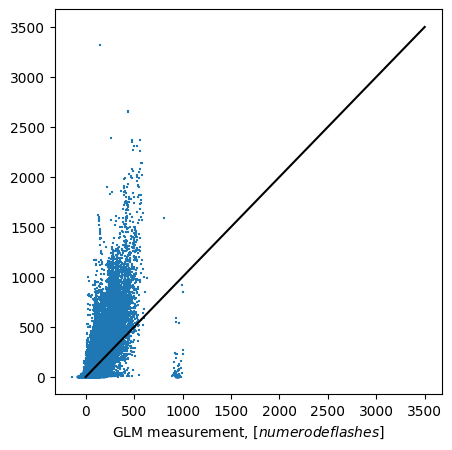

In [10]:
fig = plt.figure(figsize=(5,5))

fig.set_facecolor('w')

#Axis
ax = plt.gca()

#Plot 
ax.scatter(yhat,y_validate,s=1,marker='+')
ax.plot([0,3500],[0,3500],'-k')
ax.set_xlabel('ML Prediction, [$numero de flashes$]')
ax.set_xlabel('GLM measurement, [$numero de flashes$]')

Como se puede visualizar, la correspondencia de los datos con las predicciones es pésima. Una posible mejora podría ser quitar las imagenes con cero flashes

In [11]:
(X_train,y_train),(X_validate,y_validate),(X_test,y_test) = load_n_combine_df(features_to_keep=np.arange(0,36,1),class_labels=False,dropzeros=True)

Text(0.5, 0, 'GLM measurement, [$numero de flashes$]')

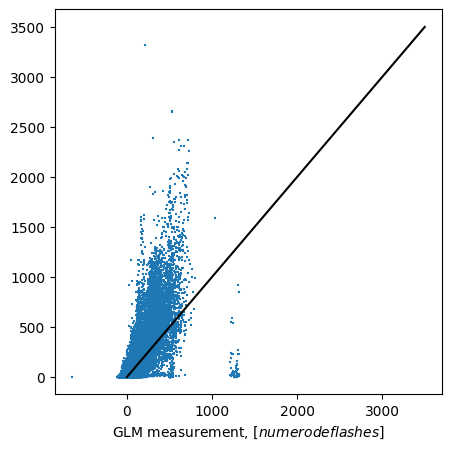

In [12]:
model = LinearRegression()
model.fit(X_train,y_train)
yhat = model.predict(X_validate)


fig = plt.figure(figsize=(5,5))

fig.set_facecolor('w')

#Axis
ax = plt.gca()

#Plot 
ax.scatter(yhat,y_validate,s=1,marker='+')
ax.plot([0,3500],[0,3500],'-k')
ax.set_xlabel('ML Prediction, [$numero de flashes$]')
ax.set_xlabel('GLM measurement, [$numero de flashes$]')

Aqui se puede visualizar que mejora considerablemente no obstante sigue siendo pésimo

Veamos según distintas métricas de error, los resultados:

In [13]:
yhat = model.predict(X_validate)
mae = mean_absolute_error(y_validate,yhat)
rmse = np.sqrt(mean_squared_error(y_validate,yhat))
bias = abs(np.mean(yhat - y_validate))
r2 = r2_score(y_validate,yhat)

print(f"R2: {r2:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | Bias: {bias:.4f}")

R2: 0.4641 | MAE: 90.1379 | RMSE: 167.5691 | Bias: 37.3140


Tratemos de volver a mejorar el resultado al realizar un escalado de los datos:

In [14]:
(X_train,y_train),(X_validate,y_validate),(X_test,y_test) = load_n_combine_df(features_to_keep=np.arange(0,36,1),class_labels=False,dropzeros=True)


Se genera el escalador

In [16]:
scaler = StandardScaler()

Lo entrenamos:

In [17]:
scaler.fit(X_train)

StandardScaler()

Transformamos los subconjuntos de datos:

In [18]:
X_train = scaler.transform(X_train)
X_validate = scaler.transform(X_validate)
X_test = scaler.transform(X_test)

Volvemos a inicializar todo el modelo y comprobamos los resultados:

In [19]:
model = LinearRegression()
model.fit(X_train,y_train)
yhat = model.predict(X_validate)

mae = mean_absolute_error(y_validate,yhat)
rmse = np.sqrt(mean_squared_error(y_validate,yhat))
bias = abs(np.mean(yhat - y_validate))
r2 = r2_score(y_validate,yhat)

print(f"R2: {r2:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | Bias: {bias:.4f}")

R2: 0.4641 | MAE: 90.1379 | RMSE: 167.5691 | Bias: 37.3140


Como se visualiza, el modelo ahora explica un 47% de la variabilidad real del mismo, aunque ha crecido, los resultados siguen siendo deficientes

## Múltiples modelos a la vez

In [3]:
(X_train,y_train),(X_validate,y_validate),(X_test,y_test) = load_n_combine_df(date = '2019-06-01',features_to_keep=np.arange(0,36,1),class_labels=False,dropzeros=True)

In [4]:
model_list = [LinearRegression(),DecisionTreeRegressor(),RandomForestRegressor(),GradientBoostingRegressor(),LinearSVR(),xgb.XGBRegressor(booster='gbtree', max_depth=5, learning_rate=0.1, n_estimators=100),xgb.XGBRegressor(booster='dart', max_depth=6, learning_rate=0.1, n_estimators=100)]

import tqdm 

for model in tqdm.tqdm(model_list):
    model.fit(X_train,y_train)

100%|██████████| 7/7 [12:54<00:00, 110.64s/it]


In [5]:
for idx,model in enumerate(model_list):
    #Predicciones
    yhat = model.predict(X_validate)
    
    mae = mean_absolute_error(y_validate,yhat)
    rmse = abs(np.sqrt(mean_squared_error(y_validate,yhat)))
    bias = abs(np.mean(yhat - y_validate))
    r2 = r2_score(y_validate,yhat)

    print(f"Method: {type(model).__name__} | R2: {r2:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | Bias: {bias:.4f}")

Method: LinearRegression | R2: 0.5036 | MAE: 90.5565 | RMSE: 158.3797 | Bias: 22.4182
Method: DecisionTreeRegressor | R2: 0.0645 | MAE: 106.8358 | RMSE: 217.4314 | Bias: 14.0038
Method: RandomForestRegressor | R2: 0.6174 | MAE: 71.8685 | RMSE: 139.0541 | Bias: 15.8943
Method: GradientBoostingRegressor | R2: 0.6387 | MAE: 72.2192 | RMSE: 135.1219 | Bias: 17.1849
Method: LinearSVR | R2: 0.3384 | MAE: 88.6859 | RMSE: 182.8572 | Bias: 55.4107
Method: XGBRegressor | R2: 0.6240 | MAE: 71.6109 | RMSE: 137.8371 | Bias: 18.5771
Method: XGBRegressor | R2: 0.6162 | MAE: 72.0079 | RMSE: 139.2742 | Bias: 20.1702


Veamoslo en una gráfica:

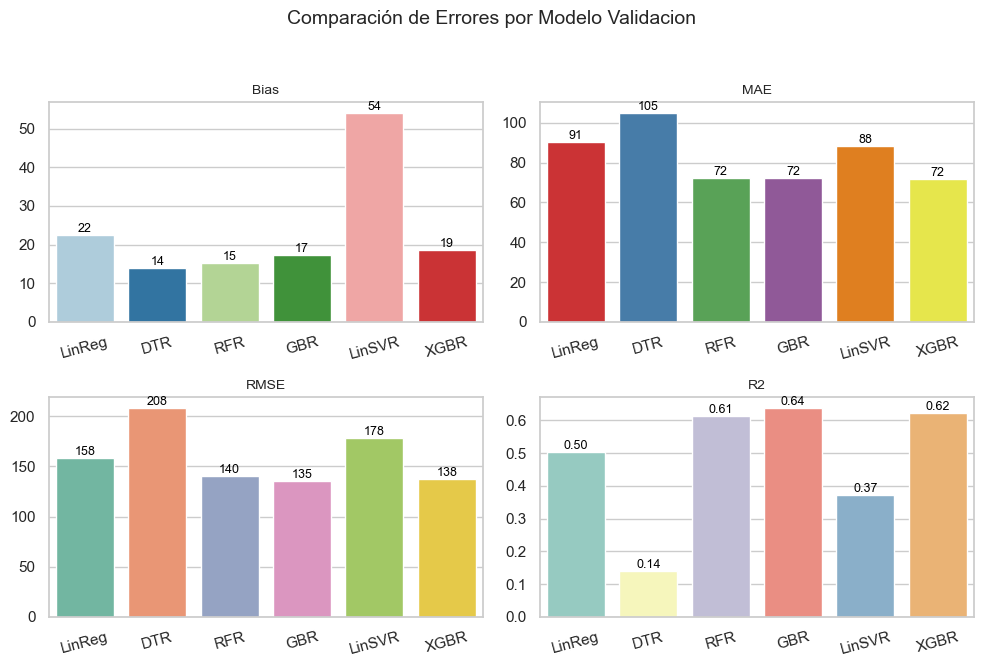

In [59]:
# Datos actualizados
data = [
    {"Metodo": "LinReg", "R2": 0.5036, "MAE": 90.5565, "RMSE": 158.3797, "Bias": 22.4182},
    {"Metodo": "DTR", "R2": 0.1411, "MAE": 105.0584, "RMSE": 208.3375, "Bias": 13.9190},
    {"Metodo": "RFR", "R2": 0.6123, "MAE": 72.2628, "RMSE": 139.9778, "Bias": 15.2727},
    {"Metodo": "GBR", "R2": 0.6385, "MAE": 72.2340, "RMSE": 135.1522, "Bias": 17.2209},
    {"Metodo": "LinSVR", "R2": 0.3725, "MAE": 88.2275, "RMSE": 178.0709, "Bias": 54.0972},
    {"Metodo": "XGBR", "R2": 0.6240, "MAE": 71.6109, "RMSE": 137.8371, "Bias": 18.5771},
]

df = pd.DataFrame(data)

# Paletas de colores
colors_mae = sns.color_palette("Set1", n_colors=len(df))
colors_rmse = sns.color_palette("Set2", n_colors=len(df))
colors_r2 = sns.color_palette("Set3", n_colors=len(df))
colors_bias = sns.color_palette("Paired", n_colors=len(df))

# Ejes y Tamaño de figura
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
fig.suptitle("Comparación de Errores por Modelo Validacion", fontsize=14)

# Métricas a graficar
metrics = [
    ("Bias", colors_bias, axes[0, 0], "%.0f"),
    ("MAE", colors_mae, axes[0, 1], "%.0f"),
    ("RMSE", colors_rmse, axes[1, 0], "%.0f"),
    ("R2", colors_r2, axes[1, 1], "%.2f")
]

# Generar gráficas
for metric, palette, ax, fmt in metrics:
    bars = sns.barplot(data=df, x="Metodo", y=metric, ax=ax, palette=palette)
    ax.set_title(metric, fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis='x', rotation=15)
    
    for i, bar in enumerate(bars.patches):
        height = bar.get_height()
        ax.annotate(fmt % height,
                    (bar.get_x() + bar.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()




Veamos que coincide también con las salidas de los modelos en el conjunto de test:

In [13]:
for idx,model in enumerate(model_list):
    #Predicciones
    yhat = model.predict(X_test)
    
    mae = mean_absolute_error(y_test,yhat)
    rmse = abs(np.sqrt(mean_squared_error(y_test,yhat)))
    bias = abs(np.mean(yhat - y_test))
    r2 = r2_score(y_test,yhat)

    print(f"Method: {type(model).__name__} | R2: {r2:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | Bias: {bias:.4f}")

Method: LinearRegression | R2: 0.5719 | MAE: 106.4204 | RMSE: 196.2177 | Bias: 41.9775
Method: DecisionTreeRegressor | R2: 0.3246 | MAE: 126.5937 | RMSE: 246.4456 | Bias: 35.1355
Method: RandomForestRegressor | R2: 0.6589 | MAE: 88.2461 | RMSE: 175.1505 | Bias: 31.8562
Method: GradientBoostingRegressor | R2: 0.6690 | MAE: 88.0461 | RMSE: 172.5201 | Bias: 30.5837
Method: LinearSVR | R2: 0.3632 | MAE: 117.9473 | RMSE: 239.3042 | Bias: 86.1584
Method: XGBRegressor | R2: 0.6608 | MAE: 87.4632 | RMSE: 174.6588 | Bias: 32.4927
Method: XGBRegressor | R2: 0.6563 | MAE: 87.3010 | RMSE: 175.8017 | Bias: 34.4211


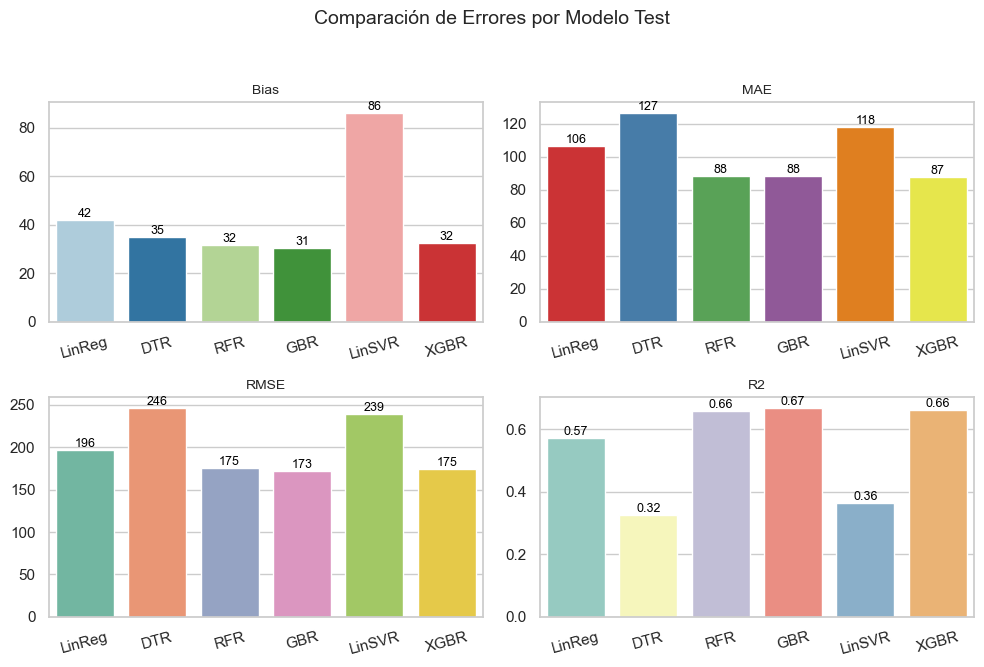

In [61]:
# Nuevos datos
data = [
    {"Metodo": "LinReg", "R2": 0.5719, "MAE": 106.4204, "RMSE": 196.2177, "Bias": 41.9775},
    {"Metodo": "DTR", "R2": 0.3246, "MAE": 126.5937, "RMSE": 246.4456, "Bias": 35.1355},
    {"Metodo": "RFR", "R2": 0.6589, "MAE": 88.2461, "RMSE": 175.1505, "Bias": 31.8562},
    {"Metodo": "GBR", "R2": 0.6690, "MAE": 88.0461, "RMSE": 172.5201, "Bias": 30.5837},
    {"Metodo": "LinSVR", "R2": 0.3632, "MAE": 117.9473, "RMSE": 239.3042, "Bias": 86.1584},
    {"Metodo": "XGBR", "R2": 0.6608, "MAE": 87.4632, "RMSE": 174.6588, "Bias": 32.4927},
]

df = pd.DataFrame(data)

# Paletas de colores
colors_mae = sns.color_palette("Set1", n_colors=len(df))
colors_rmse = sns.color_palette("Set2", n_colors=len(df))
colors_r2 = sns.color_palette("Set3", n_colors=len(df))
colors_bias = sns.color_palette("Paired", n_colors=len(df))

# Tamaño de figura
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
fig.suptitle("Comparación de Errores por Modelo Test", fontsize=14)

# Métricas a graficar
metrics = [
    ("Bias", colors_bias, axes[0, 0], "%.0f"),
    ("MAE", colors_mae, axes[0, 1], "%.0f"),
    ("RMSE", colors_rmse, axes[1, 0], "%.0f"),
    ("R2", colors_r2, axes[1, 1], "%.2f")
]

# Generar cada gráfico
for metric, palette, ax, fmt in metrics:
    bars = sns.barplot(data=df, x="Metodo", y=metric, ax=ax, palette=palette)
    ax.set_title(metric, fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis='x', rotation=15)

    for bar in bars.patches:
        height = bar.get_height()
        ax.annotate(fmt % height,
                    (bar.get_x() + bar.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Estos resultados coinciden con los presentados con el paper original.

## Optimizacion:

Se realizará distintos splits temporales de forma análoga al notebook anterior.

In [6]:
lista_fechas = ['2017-06-01','2017-12-01','2018-04-01','2018-05-01','2018-06-01','2018-12-01','2019-02-01','2019-04-01','2019-06-01']

In [10]:
(list_X_train,list_y_train),(list_X_validate,list_y_validate),(list_X_test,list_y_test) = load_n_combine_mod_df(features_to_keep=np.arange(0,36,1),class_labels=False,dropzeros=True)

In [11]:
for i in range(len(list_X_train)):
    X_train = list_X_train[i]
    y_train = list_y_train[i]
    X_validate = list_X_validate[i]
    y_validate = list_y_validate[i]
    X_test = list_X_test[i]
    y_test = list_y_test[i]

    print('----------------------------------')
    print(lista_fechas[i])

    print('X_train, y_train shapes: {},{}'.format(X_train.shape,y_train.shape))
    print('X_val, y_val shapes: {},{}'.format(X_validate.shape,y_validate.shape))
    print('X_test, y_test shapes: {},{}'.format(X_test.shape,y_test.shape))

----------------------------------
2017-06-01
X_train, y_train shapes: (0, 36),(0,)
X_val, y_val shapes: (116655, 36),(116655,)
X_test, y_test shapes: (124254, 36),(124254,)
----------------------------------
2017-12-01
X_train, y_train shapes: (0, 36),(0,)
X_val, y_val shapes: (116655, 36),(116655,)
X_test, y_test shapes: (124254, 36),(124254,)
----------------------------------
2018-04-01
X_train, y_train shapes: (2769, 36),(2769,)
X_val, y_val shapes: (116655, 36),(116655,)
X_test, y_test shapes: (124254, 36),(124254,)
----------------------------------
2018-05-01
X_train, y_train shapes: (10880, 36),(10880,)
X_val, y_val shapes: (116655, 36),(116655,)
X_test, y_test shapes: (124254, 36),(124254,)
----------------------------------
2018-06-01
X_train, y_train shapes: (26005, 36),(26005,)
X_val, y_val shapes: (114137, 36),(114137,)
X_test, y_test shapes: (124254, 36),(124254,)
----------------------------------
2018-12-01
X_train, y_train shapes: (162621, 36),(162621,)
X_val, y_val s

In [12]:
list_X_train = list_X_train[2:]
list_X_validate = list_X_validate[2:]
list_X_test = list_X_test[2:]
list_y_train = list_y_train[2:]
list_y_validate = list_y_validate[2:]
list_y_test = list_y_test[2:]
lista_fechas = lista_fechas[2:]

In [13]:
for i in range(len(list_X_train)):
    X_train = list_X_train[i]
    y_train = list_y_train[i]
    X_validate = list_X_validate[i]
    y_validate = list_y_validate[i]
    X_test = list_X_test[i]
    y_test = list_y_test[i]
    print('----------------------------------')
    print(lista_fechas[i])

    print('X_train, y_train shapes: {},{}'.format(X_train.shape,y_train.shape))
    print('X_val, y_val shapes: {},{}'.format(X_validate.shape,y_validate.shape))
    print('X_test, y_test shapes: {},{}'.format(X_test.shape,y_test.shape))

----------------------------------
2018-04-01
X_train, y_train shapes: (2769, 36),(2769,)
X_val, y_val shapes: (116655, 36),(116655,)
X_test, y_test shapes: (124254, 36),(124254,)
----------------------------------
2018-05-01
X_train, y_train shapes: (10880, 36),(10880,)
X_val, y_val shapes: (116655, 36),(116655,)
X_test, y_test shapes: (124254, 36),(124254,)
----------------------------------
2018-06-01
X_train, y_train shapes: (26005, 36),(26005,)
X_val, y_val shapes: (114137, 36),(114137,)
X_test, y_test shapes: (124254, 36),(124254,)
----------------------------------
2018-12-01
X_train, y_train shapes: (162621, 36),(162621,)
X_val, y_val shapes: (50965, 36),(50965,)
X_test, y_test shapes: (50629, 36),(50629,)
----------------------------------
2019-02-01
X_train, y_train shapes: (170073, 36),(170073,)
X_val, y_val shapes: (48670, 36),(48670,)
X_test, y_test shapes: (48630, 36),(48630,)
----------------------------------
2019-04-01
X_train, y_train shapes: (185785, 36),(185785,)
X_

In [14]:
for i in range(len(list_X_train)):

    X_train = list_X_train[i]
    y_train = list_y_train[i]
    X_validate = list_X_validate[i]
    y_validate = list_y_validate[i]

    model_list = [LinearRegression(),DecisionTreeRegressor(),RandomForestRegressor(),GradientBoostingRegressor(),LinearSVR(),xgb.XGBRegressor(booster='gbtree'),xgb.XGBRegressor(booster='dart')]

    print('----------------------------------')
    print(lista_fechas[i])
    
    import tqdm 

    for model in tqdm.tqdm(model_list):
        model.fit(X_train,y_train)

    for idx,model in enumerate(model_list):
    #Predicciones 
        yhat = model.predict(X_validate)
    
    #Metricas
        mae = mean_absolute_error(y_validate,yhat)
        rmse = np.sqrt(mean_squared_error(y_validate,yhat))
        bias = abs(np.mean(yhat - y_validate))
        r2 = r2_score(y_validate,yhat)

        print(f"Method: {type(model).__name__} | R2: {r2:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | Bias: {bias:.4f}")

----------------------------------
2018-04-01


100%|██████████| 7/7 [00:07<00:00,  1.04s/it]


Method: LinearRegression | R2: -6.7020 | MAE: 144.1304 | RMSE: 586.8407 | Bias: 45.1827
Method: DecisionTreeRegressor | R2: 0.1108 | MAE: 109.3983 | RMSE: 199.3974 | Bias: 41.5464
Method: RandomForestRegressor | R2: 0.3367 | MAE: 92.3430 | RMSE: 172.2179 | Bias: 23.4363
Method: GradientBoostingRegressor | R2: 0.3874 | MAE: 91.3475 | RMSE: 165.5028 | Bias: 26.4561
Method: LinearSVR | R2: 0.3690 | MAE: 89.0071 | RMSE: 167.9738 | Bias: 21.6847
Method: XGBRegressor | R2: 0.3729 | MAE: 91.4223 | RMSE: 167.4476 | Bias: 34.9835
Method: XGBRegressor | R2: 0.3729 | MAE: 91.4223 | RMSE: 167.4476 | Bias: 34.9834
----------------------------------
2018-05-01


100%|██████████| 7/7 [00:29<00:00,  4.19s/it]


Method: LinearRegression | R2: -6.5830 | MAE: 126.0664 | RMSE: 582.2899 | Bias: 46.6189
Method: DecisionTreeRegressor | R2: 0.1137 | MAE: 106.4671 | RMSE: 199.0759 | Bias: 9.3823
Method: RandomForestRegressor | R2: 0.4762 | MAE: 82.3607 | RMSE: 153.0330 | Bias: 16.5272
Method: GradientBoostingRegressor | R2: 0.4542 | MAE: 83.1891 | RMSE: 156.2155 | Bias: 25.9248
Method: LinearSVR | R2: 0.2356 | MAE: 91.5407 | RMSE: 184.8769 | Bias: 54.6240
Method: XGBRegressor | R2: 0.4350 | MAE: 87.0785 | RMSE: 158.9464 | Bias: 17.8625
Method: XGBRegressor | R2: 0.4350 | MAE: 87.0785 | RMSE: 158.9463 | Bias: 17.8625
----------------------------------
2018-06-01


100%|██████████| 7/7 [01:13<00:00, 10.55s/it]


Method: LinearRegression | R2: 0.4030 | MAE: 86.8223 | RMSE: 163.5165 | Bias: 43.3925
Method: DecisionTreeRegressor | R2: 0.2914 | MAE: 94.3866 | RMSE: 178.1353 | Bias: 33.4280
Method: RandomForestRegressor | R2: 0.4716 | MAE: 77.9116 | RMSE: 153.8287 | Bias: 34.9860
Method: GradientBoostingRegressor | R2: 0.4557 | MAE: 79.8008 | RMSE: 156.1229 | Bias: 41.6454
Method: LinearSVR | R2: 0.2970 | MAE: 89.4998 | RMSE: 177.4363 | Bias: 64.5455
Method: XGBRegressor | R2: 0.4304 | MAE: 82.7890 | RMSE: 159.7115 | Bias: 36.0811
Method: XGBRegressor | R2: 0.4304 | MAE: 82.7890 | RMSE: 159.7115 | Bias: 36.0811
----------------------------------
2018-12-01


100%|██████████| 7/7 [08:59<00:00, 77.01s/it] 


Method: LinearRegression | R2: 0.4594 | MAE: 91.3833 | RMSE: 168.8774 | Bias: 38.9092
Method: DecisionTreeRegressor | R2: 0.2591 | MAE: 105.7308 | RMSE: 197.7049 | Bias: 28.3289
Method: RandomForestRegressor | R2: 0.5859 | MAE: 75.6637 | RMSE: 147.7990 | Bias: 28.4206
Method: GradientBoostingRegressor | R2: 0.5706 | MAE: 77.3986 | RMSE: 150.5000 | Bias: 36.1880
Method: LinearSVR | R2: 0.2780 | MAE: 92.5626 | RMSE: 195.1622 | Bias: 42.4150
Method: XGBRegressor | R2: 0.5285 | MAE: 82.0094 | RMSE: 157.7150 | Bias: 34.4563
Method: XGBRegressor | R2: 0.5285 | MAE: 82.0094 | RMSE: 157.7150 | Bias: 34.4563
----------------------------------
2019-02-01


100%|██████████| 7/7 [09:28<00:00, 81.19s/it] 


Method: LinearRegression | R2: 0.4600 | MAE: 90.8213 | RMSE: 168.2137 | Bias: 36.5715
Method: DecisionTreeRegressor | R2: 0.2784 | MAE: 104.6974 | RMSE: 194.4500 | Bias: 30.5776
Method: RandomForestRegressor | R2: 0.5729 | MAE: 76.6062 | RMSE: 149.5931 | Bias: 28.6068
Method: GradientBoostingRegressor | R2: 0.5718 | MAE: 77.2061 | RMSE: 149.7962 | Bias: 34.8712
Method: LinearSVR | R2: 0.2537 | MAE: 93.3530 | RMSE: 197.7498 | Bias: 46.1911
Method: XGBRegressor | R2: 0.5068 | MAE: 82.8020 | RMSE: 160.7622 | Bias: 34.0146
Method: XGBRegressor | R2: 0.5068 | MAE: 82.8020 | RMSE: 160.7622 | Bias: 34.0146
----------------------------------
2019-04-01


100%|██████████| 7/7 [10:27<00:00, 89.59s/it] 


Method: LinearRegression | R2: 0.4689 | MAE: 89.8373 | RMSE: 166.8223 | Bias: 35.5837
Method: DecisionTreeRegressor | R2: 0.2119 | MAE: 107.2930 | RMSE: 203.2062 | Bias: 26.0454
Method: RandomForestRegressor | R2: 0.5730 | MAE: 76.4665 | RMSE: 149.5779 | Bias: 27.0197
Method: GradientBoostingRegressor | R2: 0.5772 | MAE: 76.5524 | RMSE: 148.8332 | Bias: 33.2168
Method: LinearSVR | R2: 0.2682 | MAE: 92.8375 | RMSE: 195.8146 | Bias: 54.2870
Method: XGBRegressor | R2: 0.5257 | MAE: 82.1523 | RMSE: 157.6466 | Bias: 32.5226
Method: XGBRegressor | R2: 0.5257 | MAE: 82.1523 | RMSE: 157.6466 | Bias: 32.5226
----------------------------------
2019-06-01


100%|██████████| 7/7 [12:50<00:00, 110.07s/it]


Method: LinearRegression | R2: 0.5036 | MAE: 90.5565 | RMSE: 158.3797 | Bias: 22.4182
Method: DecisionTreeRegressor | R2: 0.0563 | MAE: 106.9644 | RMSE: 218.3757 | Bias: 14.0770
Method: RandomForestRegressor | R2: 0.6115 | MAE: 72.3370 | RMSE: 140.1114 | Bias: 15.6651
Method: GradientBoostingRegressor | R2: 0.6387 | MAE: 72.2158 | RMSE: 135.1227 | Bias: 17.1610
Method: LinearSVR | R2: 0.2840 | MAE: 95.1198 | RMSE: 190.2161 | Bias: 73.2621
Method: XGBRegressor | R2: 0.5665 | MAE: 77.0937 | RMSE: 148.0131 | Bias: 20.2300
Method: XGBRegressor | R2: 0.5665 | MAE: 77.0937 | RMSE: 148.0131 | Bias: 20.2299


Al contrario que en el modelo clasificatorio, aquí no podemos deshacernos de parte de conjunto de datos de entrenaminto y pasarlo a validación o test debido a la diferencia existente en ciertos algoritmos como XGBoost o GradientBoostingRegressor.

## Hiperparametros:

Se realiza una busqueda de hiperparametros sobre cada modelo de forma individual

Se cargan los datos:

In [4]:
(X_train,y_train),(X_validate,y_validate),(X_test,y_test) = load_n_combine_df(date = '2019-06-01',features_to_keep=np.arange(0,36,1),class_labels=False,dropzeros=True)

DecisionTreeRegressor:

In [5]:
model = DecisionTreeRegressor()

In [ ]:
param = {'criterion':['squared_error','friedman_mse','absolute_error','poisson'],
          'splitter':['best','random'],
          'max_depth':[1,2,3,4,5,6,7,8,10,11,12],
          'max_features':['sqrt', 'log2']}

In [9]:
clf = RandomizedSearchCV(model, param, cv=5,scoring='neg_root_mean_squared_error', verbose=VERBOSE, n_jobs=-1, n_iter=100)
clf.fit(X_train, y_train)
plot_grid_search(clf)
table_grid_search(clf)

,mean_test_score,mean_fit_time,mean_score_time,param_splitter,param_max_features,param_max_depth,param_criterion
9,-172.934527,0.805,0.006308,best,sqrt,6,poisson


RandomForest:

In [10]:
model = RandomForestRegressor()

In [11]:
param = {
    'n_estimators': [10, 50, 100, 200],
    # 'criterion': ['mse', 'mae'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 5, 10, 15],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2, 0.3, 0.4],
    'max_features': [None,'sqrt', 'log2'],
    'max_leaf_nodes': [None, 10, 20, 30, 40, 50],
    'min_impurity_decrease': [0.0, 0.1, 0.2, 0.3, 0.4],
    'bootstrap': [True, False]
}

In [12]:
clf = RandomizedSearchCV(model, param, cv=5,scoring='neg_root_mean_squared_error', verbose=VERBOSE, n_jobs=-1,n_iter=100)
clf.fit(X_train, y_train)
plot_grid_search(clf)
table_grid_search(clf)

,mean_test_score,mean_fit_time,mean_score_time,param_n_estimators,param_min_weight_fraction_leaf,param_min_samples_split,param_min_samples_leaf,param_min_impurity_decrease,param_max_leaf_nodes,param_max_features,param_max_depth,param_bootstrap
79,-162.229572,110.687863,0.542593,100,0.0,2,10,0.4,None,sqrt,10,False


GradientBoosting:

In [13]:
model = GradientBoostingRegressor()

In [14]:
param = {
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'subsample': [0.5, 0.75, 1.0],
    # 'criterion': ['friedman_mse', 'mse', 'mae'],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 5, 10, 15],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2, 0.3, 0.4],
    'max_depth': [3, 10, 20, 30, 40, 50],
    'min_impurity_decrease': [0.0, 0.1, 0.2, 0.3, 0.4],
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 10, 20, 30, 40, 50],
    'alpha': [0.1, 0.5, 0.9],
    'validation_fraction': [0.1, 0.2, 0.3],
    'n_iter_no_change': [None, 5, 10, 15],
    'tol': [1e-4, 1e-3, 1e-2, 1e-1]
}

In [33]:
clf = RandomizedSearchCV(model, param, cv=5,scoring='neg_root_mean_squared_error', verbose=VERBOSE, n_jobs=-1,n_iter=100)
clf.fit(X_train, y_train)
plot_grid_search(clf)
table_grid_search(clf)


,mean_test_score,mean_fit_time,mean_score_time,param_validation_fraction,param_tol,param_subsample,param_n_iter_no_change,param_n_estimators,param_min_weight_fraction_leaf,param_min_samples_split,param_min_samples_leaf,param_min_impurity_decrease,param_max_leaf_nodes,param_max_features,param_max_depth,param_learning_rate,param_alpha
60,-161.770422,240.885008,0.503562,0.1,0.1,0.5,10,200,0.0,15,5,0.2,30,None,3,0.01,0.5


LinearSVR:

In [41]:
model = LinearSVR()

In [42]:
param = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']
    }

In [43]:
clf = GridSearchCV(model, param, cv=5,scoring='neg_root_mean_squared_error', verbose=VERBOSE, n_jobs=-1)
clf.fit(X_train, y_train)
plot_grid_search(clf)
table_grid_search(clf)

,mean_test_score,mean_fit_time,mean_score_time,param_C,param_loss
0,-166.687763,1.388333,0.00798,0.001,epsilon_insensitive


XGBoost:

In [34]:
model = xgb.XGBRFRegressor()

In [35]:
param = {
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9, 12],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.5, 0.75, 1.0],
    'colsample_bytree': [0.5, 0.75, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0],
    'scale_pos_weight': [1, 2, 3, 4],
    'booster': ['gbtree', 'dart'],
    'tree_method': ['exact', 'approx', 'hist', 'gpu_hist'],
    'grow_policy': ['depthwise', 'lossguide'],
    'max_leaves': [0, 10, 20, 30, 40, 50],
    'sampling_method': ['uniform', 'gradient_based']
}

In [36]:
clf = RandomizedSearchCV(model, param, cv=5,scoring='neg_root_mean_squared_error', verbose=VERBOSE, n_jobs=-1, n_iter=100)
clf.fit(X_train, y_train)
plot_grid_search(clf)
table_grid_search(clf)

,mean_test_score,mean_fit_time,mean_score_time,param_tree_method,param_subsample,param_scale_pos_weight,param_sampling_method,param_reg_lambda,param_reg_alpha,param_n_estimators,param_min_child_weight,param_max_leaves,param_max_depth,param_learning_rate,param_grow_policy,param_gamma,param_colsample_bytree,param_booster
71,-195.048709,4.532942,2.334999,hist,0.5,3,uniform,0.0,0.1,100,1,30,9,0.2,depthwise,0.4,1.0,dart


Comparemos, primero el modelo sin nada:

In [22]:
(X_train,y_train),(X_validate,y_validate),(X_test,y_test) = load_n_combine_df(date = '2019-06-01',features_to_keep=np.arange(0,36,1),class_labels=False,dropzeros=True)

In [10]:
model_list = [LinearRegression(),DecisionTreeRegressor(),RandomForestRegressor(),GradientBoostingRegressor(),LinearSVR(),xgb.XGBRegressor(booster='gbtree', max_depth=5, learning_rate=0.1, n_estimators=100),xgb.XGBRegressor(booster='dart', max_depth=6, learning_rate=0.1, n_estimators=100)]

import tqdm 

for model in tqdm.tqdm(model_list):
    model.fit(X_train,y_train)

100%|██████████| 7/7 [13:57<00:00, 119.71s/it]


In [11]:
for idx,model in enumerate(model_list):
    #Predicciones
    yhat = model.predict(X_validate)
    
    mae = mean_absolute_error(y_validate,yhat)
    rmse = abs(np.sqrt(mean_squared_error(y_validate,yhat)))
    bias = abs(np.mean(yhat - y_validate))
    r2 = r2_score(y_validate,yhat)

    print(f"Method: {type(model).__name__} | R2: {r2:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | Bias: {bias:.4f}")

Method: LinearRegression | R2: 0.5036 | MAE: 90.5565 | RMSE: 158.3797 | Bias: 22.4182
Method: DecisionTreeRegressor | R2: 0.1573 | MAE: 105.3199 | RMSE: 206.3609 | Bias: 14.2603
Method: RandomForestRegressor | R2: 0.6136 | MAE: 72.1956 | RMSE: 139.7405 | Bias: 16.0120
Method: GradientBoostingRegressor | R2: 0.6387 | MAE: 72.2174 | RMSE: 135.1255 | Bias: 17.1594
Method: LinearSVR | R2: 0.3464 | MAE: 88.1259 | RMSE: 181.7425 | Bias: 52.8057
Method: XGBRegressor | R2: 0.6240 | MAE: 71.6109 | RMSE: 137.8371 | Bias: 18.5771
Method: XGBRegressor | R2: 0.6162 | MAE: 72.0079 | RMSE: 139.2742 | Bias: 20.1702


Modelo con los hiperparamteros ajustados:

In [5]:
model_list = [
    LinearRegression(),  # No tiene hiperparámetros configurados

    DecisionTreeRegressor(
        splitter="best",
        max_features="sqrt",
        max_depth=6,
        criterion="poisson"
    ),

    RandomForestRegressor(
        n_estimators=100,
        min_weight_fraction_leaf=0.0,
        min_samples_split=2,
        min_samples_leaf=10,
        min_impurity_decrease=0.4,
        max_leaf_nodes=None,
        max_features="sqrt",
        max_depth=10,
        bootstrap=False
    ),

    GradientBoostingRegressor(
        validation_fraction=0.1,
        tol=0.1,
        subsample=0.5,
        n_iter_no_change=10,
        n_estimators=200,
        min_weight_fraction_leaf=0.0,
        min_samples_split=15,
        min_samples_leaf=5,
        min_impurity_decrease=0.2,
        max_leaf_nodes=30,
        max_features=None,
        max_depth=3,
        learning_rate=0.01,
        alpha=0.5
    ),

    LinearSVR(
        C=0.001,
        loss="epsilon_insensitive"
    ),

    xgb.XGBRegressor(
        booster="gbtree"
    ),

    xgb.XGBRegressor(
        booster="dart",
        tree_method="hist",
        subsample=0.5,
        scale_pos_weight=3,
        sampling_method="uniform",
        reg_lambda=0.0,
        reg_alpha=0.1,
        n_estimators=100,
        min_child_weight=1,
        max_leaves=30,
        max_depth=9,
        learning_rate=0.2,
        grow_policy="depthwise",
        gamma=0.4,
        colsample_bytree=1.0
    )
]

In [9]:
import tqdm 
for model in tqdm.tqdm(model_list):
    model.fit(X_train,y_train)

for idx,model in enumerate(model_list):
    #Predicciones
    yhat = model.predict(X_validate)
    
    mae = mean_absolute_error(y_validate,yhat)
    rmse = abs(np.sqrt(mean_squared_error(y_validate,yhat)))
    bias = abs(np.mean(yhat - y_validate))
    r2 = r2_score(y_validate,yhat)

    print(f"Method: {type(model).__name__} | R2: {r2:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | Bias: {bias:.4f}")

100%|██████████| 7/7 [04:19<00:00, 37.09s/it]


Method: LinearRegression | R2: 0.5036 | MAE: 90.5565 | RMSE: 158.3797 | Bias: 22.4182
Method: DecisionTreeRegressor | R2: 0.5230 | MAE: 85.9865 | RMSE: 155.2545 | Bias: 13.5549
Method: RandomForestRegressor | R2: 0.6081 | MAE: 75.0475 | RMSE: 140.7218 | Bias: 17.1043
Method: GradientBoostingRegressor | R2: 0.5743 | MAE: 81.7696 | RMSE: 146.6659 | Bias: 15.1822
Method: LinearSVR | R2: 0.3855 | MAE: 89.7082 | RMSE: 176.2282 | Bias: 55.0315
Method: XGBRegressor | R2: 0.5665 | MAE: 77.0937 | RMSE: 148.0131 | Bias: 20.2300
Method: XGBRegressor | R2: 0.5866 | MAE: 74.4193 | RMSE: 144.5375 | Bias: 21.5281


Veamos en una gráfica los resultados finales de los modelos tras la búsqueda de hiperparámetros:

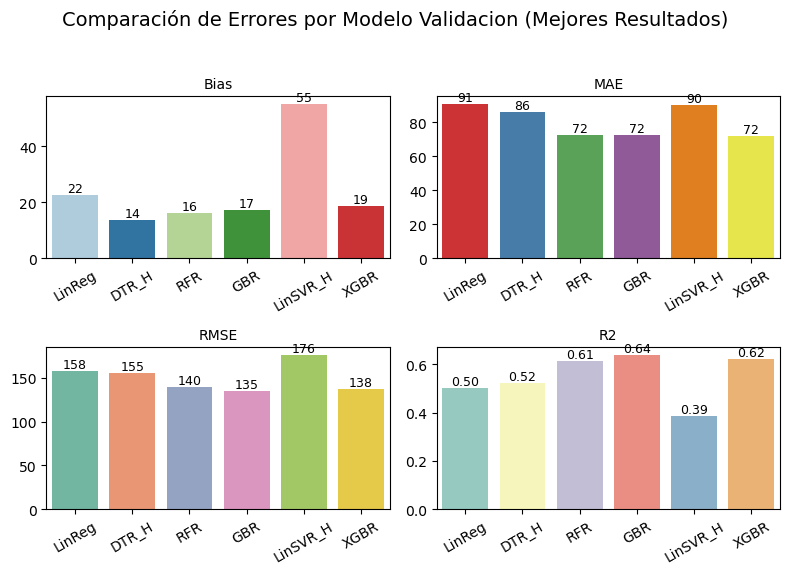

In [39]:
#Si añade _H al nombre significa que el mejor modelo es el obtenido tras la búsqueda de Hip
data = [
    {"Metodo": "LinReg", "R2": 0.5036, "MAE": 90.5565, "RMSE": 158.3797, "Bias": 22.4182},
    {"Metodo": "DTR_H", "R2": 0.5230, "MAE": 85.9865, "RMSE": 155.2545, "Bias": 13.5549},
    {"Metodo": "RFR", "R2": 0.6136, "MAE": 72.1956, "RMSE": 139.7405, "Bias": 16.0120},
    {"Metodo": "GBR", "R2": 0.6387, "MAE": 72.2174, "RMSE": 135.1255, "Bias": 17.1594},
    {"Metodo": "LinSVR_H", "R2": 0.3855, "MAE": 89.7082, "RMSE": 176.2282, "Bias": 55.0315},
    {"Metodo": "XGBR", "R2": 0.6240, "MAE": 71.6109, "RMSE": 137.8371, "Bias": 18.5771},
]

df = pd.DataFrame(data)

# Paletas de cada plot
colors_mae = sns.color_palette("Set1", n_colors=6)
colors_rmse = sns.color_palette("Set2", n_colors=6)
colors_r2 = sns.color_palette("Set3", n_colors=6)
colors_bias = sns.color_palette("Paired", n_colors=6)

# Ejes y Tamaño
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
fig.suptitle("Comparación de Errores por Modelo Validacion (Mejores Resultados)", fontsize=14)

# Datos para cada plot:
metrics = [
    ("Bias", colors_bias, axes[0, 0], "%.0f"),
    ("MAE", colors_mae, axes[0, 1], "%.0f"),
    ("RMSE", colors_rmse, axes[1, 0], "%.0f"),
    ("R2", colors_r2, axes[1, 1], "%.2f")
]

# Plot con anotaciones
for metric, palette, ax, fmt in metrics:
    bars = sns.barplot(data=df, x="Metodo", y=metric, ax=ax, palette=palette)
    ax.set_title(metric, fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis='x', rotation=30)  # Rotación de nombres

    for i, bar in enumerate(bars.patches):
        height = bar.get_height()
        ax.annotate(fmt % height,
                    (bar.get_x() + bar.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



Realizando lo mismo sobre el subconjunto de test:

In [24]:
model_list = [LinearRegression(),DecisionTreeRegressor(),RandomForestRegressor(),GradientBoostingRegressor(),LinearSVR(),xgb.XGBRegressor(booster='gbtree', max_depth=5, learning_rate=0.1, n_estimators=100),xgb.XGBRegressor(booster='dart', max_depth=6, learning_rate=0.1, n_estimators=100)]

import tqdm 

for model in tqdm.tqdm(model_list):
    model.fit(X_train,y_train)

100%|██████████| 7/7 [14:01<00:00, 120.24s/it]


In [25]:
for idx,model in enumerate(model_list):
    #Predicciones
    yhat = model.predict(X_test)
    
    mae = mean_absolute_error(y_test,yhat)
    rmse = abs(np.sqrt(mean_squared_error(y_test,yhat)))
    bias = abs(np.mean(yhat - y_test))
    r2 = r2_score(y_test,yhat)

    print(f"Method: {type(model).__name__} | R2: {r2:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | Bias: {bias:.4f}")

Method: LinearRegression | R2: 0.5719 | MAE: 106.4204 | RMSE: 196.2177 | Bias: 41.9775
Method: DecisionTreeRegressor | R2: 0.3102 | MAE: 127.3364 | RMSE: 249.0659 | Bias: 34.7640
Method: RandomForestRegressor | R2: 0.6557 | MAE: 88.4179 | RMSE: 175.9600 | Bias: 31.9617
Method: GradientBoostingRegressor | R2: 0.6693 | MAE: 87.9943 | RMSE: 172.4364 | Bias: 30.6021
Method: LinearSVR | R2: 0.2965 | MAE: 118.7870 | RMSE: 251.5255 | Bias: 83.9558
Method: XGBRegressor | R2: 0.6608 | MAE: 87.4632 | RMSE: 174.6588 | Bias: 32.4927
Method: XGBRegressor | R2: 0.6563 | MAE: 87.3010 | RMSE: 175.8017 | Bias: 34.4211


In [29]:
model_list = [
    LinearRegression(),  # No tiene hiperparámetros configurados

    DecisionTreeRegressor(
        splitter="best",
        max_features="sqrt",
        max_depth=6,
        criterion="poisson"
    ),

    RandomForestRegressor(
        n_estimators=100,
        min_weight_fraction_leaf=0.0,
        min_samples_split=2,
        min_samples_leaf=10,
        min_impurity_decrease=0.4,
        max_leaf_nodes=None,
        max_features="sqrt",
        max_depth=10,
        bootstrap=False
    ),

    GradientBoostingRegressor(
        validation_fraction=0.1,
        tol=0.1,
        subsample=0.5,
        n_iter_no_change=10,
        n_estimators=200,
        min_weight_fraction_leaf=0.0,
        min_samples_split=15,
        min_samples_leaf=5,
        min_impurity_decrease=0.2,
        max_leaf_nodes=30,
        max_features=None,
        max_depth=3,
        learning_rate=0.01,
        alpha=0.5
    ),

    LinearSVR(
        C=0.001,
        loss="epsilon_insensitive"
    ),

    xgb.XGBRegressor(
        booster="gbtree"
    ),

    xgb.XGBRegressor(
        booster="dart",
        tree_method="hist",
        subsample=0.5,
        scale_pos_weight=3,
        sampling_method="uniform",
        reg_lambda=0.0,
        reg_alpha=0.1,
        n_estimators=100,
        min_child_weight=1,
        max_leaves=30,
        max_depth=9,
        learning_rate=0.2,
        grow_policy="depthwise",
        gamma=0.4,
        colsample_bytree=1.0
    )
]

In [31]:
for model in tqdm.tqdm(model_list):
    model.fit(X_train,y_train)

100%|██████████| 7/7 [04:34<00:00, 39.27s/it]


In [32]:
for idx,model in enumerate(model_list):
    #Predicciones
    yhat = model.predict(X_test)
    
    mae = mean_absolute_error(y_test,yhat)
    rmse = abs(np.sqrt(mean_squared_error(y_test,yhat)))
    bias = abs(np.mean(yhat - y_test))
    r2 = r2_score(y_test,yhat)

    print(f"Method: {type(model).__name__} | R2: {r2:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | Bias: {bias:.4f}")

Method: LinearRegression | R2: 0.5719 | MAE: 106.4204 | RMSE: 196.2177 | Bias: 41.9775
Method: DecisionTreeRegressor | R2: 0.5087 | MAE: 108.2352 | RMSE: 210.1866 | Bias: 43.1277
Method: RandomForestRegressor | R2: 0.6145 | MAE: 94.2657 | RMSE: 186.1896 | Bias: 36.3979
Method: GradientBoostingRegressor | R2: 0.5920 | MAE: 101.0774 | RMSE: 191.5379 | Bias: 36.8479
Method: LinearSVR | R2: 0.4086 | MAE: 116.6194 | RMSE: 230.6076 | Bias: 83.7312
Method: XGBRegressor | R2: 0.6317 | MAE: 92.2561 | RMSE: 181.9779 | Bias: 34.5378
Method: XGBRegressor | R2: 0.6544 | MAE: 88.9464 | RMSE: 176.2995 | Bias: 34.6035


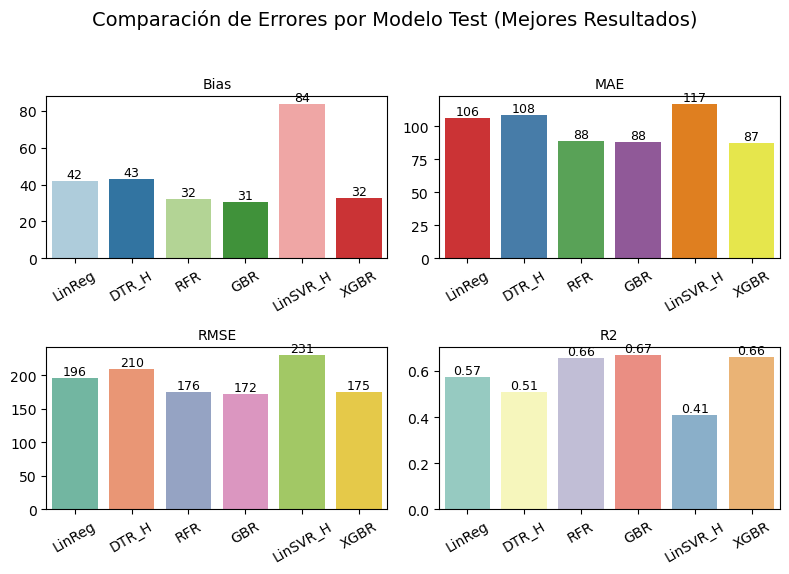

In [37]:
# Datos
data = [
    {"Metodo": "LinReg", "R2": 0.5719, "MAE": 106.4204, "RMSE": 196.2177, "Bias": 41.9775},
    {"Metodo": "DTR_H", "R2": 0.5087, "MAE": 108.2352, "RMSE": 210.1866, "Bias": 43.1277},
    {"Metodo": "RFR", "R2": 0.6557, "MAE": 88.4179, "RMSE": 175.9600, "Bias": 31.9617},
    {"Metodo": "GBR", "R2": 0.6693, "MAE": 87.9943, "RMSE": 172.4364, "Bias": 30.6021},
    {"Metodo": "LinSVR_H", "R2": 0.4086, "MAE": 116.6194, "RMSE": 230.6076, "Bias": 83.7312},
    {"Metodo": "XGBR", "R2": 0.6608, "MAE": 87.4632, "RMSE": 174.6588, "Bias": 32.4927},
]

df = pd.DataFrame(data)

# Paletas de cada plot
colors_mae = sns.color_palette("Set1", n_colors=6)
colors_rmse = sns.color_palette("Set2", n_colors=6)
colors_r2 = sns.color_palette("Set3", n_colors=6)
colors_bias = sns.color_palette("Paired", n_colors=6)

# Ejes y Tamaño
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
fig.suptitle("Comparación de Errores por Modelo Test (Mejores Resultados)", fontsize=14)

# Datos para cada plot:
metrics = [
    ("Bias", colors_bias, axes[0, 0], "%.0f"),
    ("MAE", colors_mae, axes[0, 1], "%.0f"),
    ("RMSE", colors_rmse, axes[1, 0], "%.0f"),
    ("R2", colors_r2, axes[1, 1], "%.2f")
]

# Plot con anotaciones
for metric, palette, ax, fmt in metrics:
    bars = sns.barplot(data=df, x="Metodo", y=metric, ax=ax, palette=palette)
    ax.set_title(metric, fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis='x', rotation=30)  # Rotación de nombres

    for i, bar in enumerate(bars.patches):
        height = bar.get_height()
        ax.annotate(fmt % height,
                    (bar.get_x() + bar.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Stacking:

Se volverá a usar el modelo de stacking para intentar mejorar las predicciones.

In [7]:
(X_train,y_train),(X_validate,y_validate),(X_test,y_test) = load_n_combine_df(date ='2019-06-01', features_to_keep=np.arange(0,36,1),class_labels=False,dropzeros=True)

Se procederá a realizar dos meta-modelos, uno con la Regresión Ridge y otro con GradientBoostingRegressor. Vease primero el Ridge:

In [8]:
model_list = [
    ('lr', LinearRegression()),
    ('dt', DecisionTreeRegressor()),
    ('rf', RandomForestRegressor()),
    ('gbr', GradientBoostingRegressor()),
    ('svr',  LinearSVR()),
    ('xgb_tree', xgb.XGBRegressor(booster='gbtree', max_depth=5, learning_rate=0.1, n_estimators=100))
]

# Crear y entrenar el modelo de stacking
meta_model = Ridge(alpha=1.0)
stack_model = StackingRegressor(
    estimators=model_list,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1 
)

print("Entrenando modelo de stacking...")
stack_model.fit(X_train, y_train)

# Evaluación con RMSE
y_pred = stack_model.predict(X_test)

# Métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
bias = np.mean(y_pred - y_test)

# Resultados
print(f'RMSE del modelo de stacking: {rmse:.4f}')
print(f'R² del modelo de stacking: {r2:.4f}')
print(f'MAE del modelo de stacking: {mae:.4f}')
print(f'Bias del modelo de stacking: {bias:.4f}')

Entrenando modelo de stacking...
RMSE del modelo de stacking: 186.2820
R² del modelo de stacking: 0.6141
MAE del modelo de stacking: 94.6653
Bias del modelo de stacking: -36.8508


Ahora veamos su metrica sin los modelos que más nos estropean las predicciones:

In [9]:
model_list = [
    ('rf', RandomForestRegressor()),
    ('gbr', GradientBoostingRegressor()),
    ('xgb_tree', xgb.XGBRegressor(booster='gbtree', max_depth=5, learning_rate=0.1, n_estimators=100, objective='reg:squarederror')),
    ('xgb_dart', xgb.XGBRegressor(booster='dart', max_depth=6, learning_rate=0.1, n_estimators=100, objective='reg:squarederror'))
]

# Crear y entrenar el modelo de stacking
meta_model = Ridge(alpha=1.0)
stack_model = StackingRegressor(
    estimators=model_list,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1 
)


print("Entrenando modelo de stacking...")
stack_model.fit(X_train, y_train)


y_pred = stack_model.predict(X_test)

# Métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
bias = np.mean(y_pred - y_test)

# Resultados
print(f'RMSE del modelo de stacking: {rmse:.4f}')
print(f'R² del modelo de stacking: {r2:.4f}')
print(f'MAE del modelo de stacking: {mae:.4f}')
print(f'Bias del modelo de stacking: {bias:.4f}')

Entrenando modelo de stacking...
RMSE del modelo de stacking: 179.1165
R² del modelo de stacking: 0.6432
MAE del modelo de stacking: 91.8410
Bias del modelo de stacking: -34.2089


179.52

Se procede a ver con GradientBoostingRegressor

In [10]:
model_list = [
    ('lr', LinearRegression()),
    ('dt', DecisionTreeRegressor()),
    ('rf', RandomForestRegressor()),
    ('gbr', GradientBoostingRegressor()),
    ('svr',  LinearSVR()),
    ('xgb_tree', xgb.XGBRegressor(booster='gbtree', max_depth=5, learning_rate=0.1, n_estimators=100))
]

# Crear y entrenar el modelo de stacking
meta_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
stack_model = StackingRegressor(
    estimators=model_list,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1 
    )

print("Entrenando modelo de stacking...")
stack_model.fit(X_train, y_train)

y_pred = stack_model.predict(X_test)

# Métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
bias = np.mean(y_pred - y_test)

# Resultados
print(f'RMSE del modelo de stacking: {rmse:.4f}')
print(f'R² del modelo de stacking: {r2:.4f}')
print(f'MAE del modelo de stacking: {mae:.4f}')
print(f'Bias del modelo de stacking: {bias:.4f}')

Entrenando modelo de stacking...
RMSE del modelo de stacking: 194.4874
R² del modelo de stacking: 0.5794
MAE del modelo de stacking: 92.7940
Bias del modelo de stacking: -35.8551


En este caso como podemos ver, realizar stacking no mejora los resultados predictivos. En este caso se debe a la naturaleza de los datos y de los propios modelos anteriormente realizados. Al realizar stacking se debe tener en cuenta ciertas cosas, entre ellas, la diversidad de los modelos usados a la hora de la predicción para el meta-modelo posterior, ya que si no se usan modelos de distintas naturalezas, es decir, lineales, árboles, redes neuronales, lo más probable es que el modelo de stacking no mejore los resultados debido a la incapacidad de aprendizaje causado por la similitud en los algoritmos previos que darán resultados similares. Asimismo si se usan métodos ensemble, seguramente ya se esté cerca de la mayor precisión posible dado el conjunto de datos y el margen de mejora sea ínfimo como se ha visto en el caso del problema 1.

En este caso en concreto, los modelos que no son de tipo bosque o en otras palabras, ensembles, tienen un redimiento mucho peor, lo cual va a causar que si se usan para las predicciones, en el meta-modelo final sea peor. En consecuencia, esto nos deja únicamente con los modelos de tipo ensemble y como antes se ha comentado, esto no da la suficiente diversidad como para que el modelo mejore. Por ende, en este caso realizar stacking no va a proporcionarnos mejores resultados.

Todo esto se ve reflejado en los intentos de arriba de realizar stacking en los que no se nota mejoría alguna respecto a los modelos previos.

Veamos por si acaso el modelo de stacking con los mejores modelos encontrados durante todas las pruebas:

In [11]:
model_list = [
    ('lr', LinearRegression()),
    ('dt',  DecisionTreeRegressor(splitter="best",max_features="sqrt",max_depth=6,criterion="poisson")),
    ('rf', RandomForestRegressor()),
    ('gbr', GradientBoostingRegressor()),
    ('svr', LinearSVR(C=0.001,loss="epsilon_insensitive")),
    ('xgb_tree', xgb.XGBRegressor(booster='gbtree', max_depth=5, learning_rate=0.1, n_estimators=100)),
    ('xgb_dart', xgb.XGBRegressor(booster='dart', max_depth=6, learning_rate=0.1, n_estimators=100))
]

# Crear y entrenar el modelo de stacking
meta_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
stack_model = StackingRegressor(
    estimators=model_list,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1 
    )

print("Entrenando modelo de stacking...")
stack_model.fit(X_train, y_train)

y_pred = stack_model.predict(X_test)

# Métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
bias = np.mean(y_pred - y_test)

# Resultados
print(f'RMSE del modelo de stacking: {rmse:.4f}')
print(f'R² del modelo de stacking: {r2:.4f}')
print(f'MAE del modelo de stacking: {mae:.4f}')
print(f'Bias del modelo de stacking: {bias:.4f}')

Entrenando modelo de stacking...
RMSE del modelo de stacking: 190.6463
R² del modelo de stacking: 0.5958
MAE del modelo de stacking: 93.0379
Bias del modelo de stacking: -38.8582


Si graficamos los resultados de todos los modelos de Stacking:

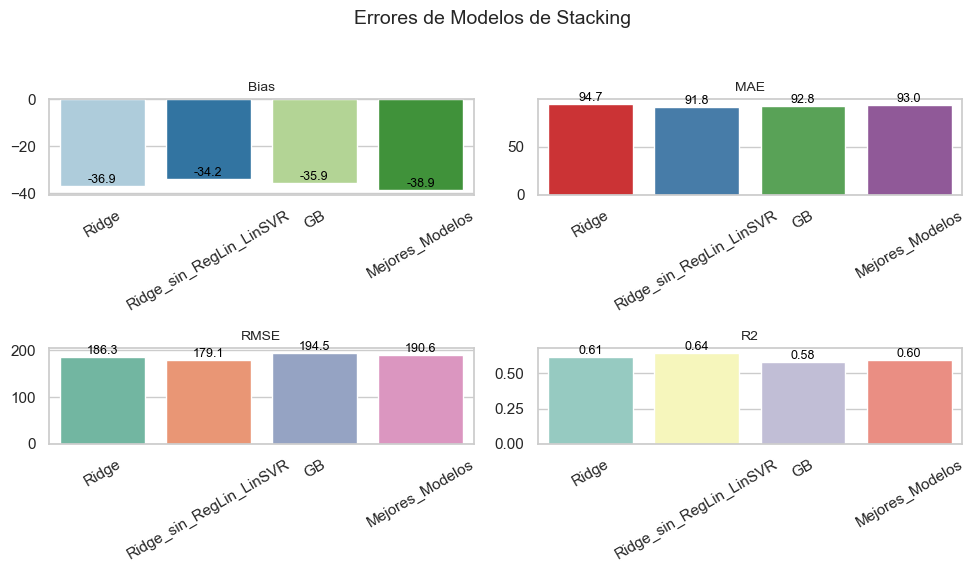

In [87]:
data = [
    {"Metodo": "Ridge", "RMSE": 186.2820, "R2": 0.6141, "MAE": 94.6653, "Bias": -36.8508},
    {"Metodo": "Ridge_sin_RegLin_LinSVR", "RMSE": 179.1165, "R2": 0.6432, "MAE": 91.8410, "Bias": -34.2089},
    {"Metodo": "GB", "RMSE": 194.4874, "R2": 0.5794, "MAE": 92.7940, "Bias": -35.8551},
    {"Metodo": "Mejores_Modelos", "RMSE": 190.6463, "R2": 0.5958, "MAE": 93.0379, "Bias": -38.8582},
]

df = pd.DataFrame(data)

# Paletas de color
colors_mae = sns.color_palette("Set1", n_colors=4)
colors_rmse = sns.color_palette("Set2", n_colors=4)
colors_r2 = sns.color_palette("Set3", n_colors=4)
colors_bias = sns.color_palette("Paired", n_colors=4)

# Ejes y tamaño
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
fig.suptitle("Errores de Modelos de Stacking", fontsize=14)

# Métricas para cada Plot
metrics = [
    ("Bias", colors_bias, axes[0, 0], "%.1f"),
    ("MAE", colors_mae, axes[0, 1], "%.1f"),
    ("RMSE", colors_rmse, axes[1, 0], "%.1f"),
    ("R2", colors_r2, axes[1, 1], "%.2f")
]

# Plot
for metric, palette, ax, fmt in metrics:
    bars = sns.barplot(data=df, x="Metodo", y=metric, ax=ax, palette=palette)
    ax.set_title(metric, fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis='x', rotation=30)  # Mejor legibilidad

    for bar in bars.patches:
        height = bar.get_height()
        ax.annotate(fmt % height,
                    (bar.get_x() + bar.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Grafica Comparativa resultados Artículo vs Propios:

Para el subconjunto de validacion:

In [ ]:
# Datos Artículo Original
datos_articulo = {
    'Modelo': ['GBT', 'ANN', 'CNN', 'U-Net_P', 'U-Net_I'],
    'Bias': [26, 39, 54, 3, 123],
    'MAE': [80, 79, 82, 3, 127],
    'RMSE': [147, 147, 157, 7, 223],
    'R2': [0.60, 0.59, 0.54, 0.60, 0.07],
    'Fuente': ['Artículo Original'] * 5
}

# Datos Trabajo Propio
datos_trabajo = {
    'Modelo': ['GBT', 'ANN', 'CNN', 'U-Net_P', 'U-Net_I'],
    'Bias': [15.37, 20.54, 20.54, -0.04, 47.44],
    'MAE': [46.33, 48.23, 50.25, 0.04, 55.62],
    'RMSE': [109.25, 110.97, 110.1, 0.7, 145.85],
    'R2': [0.67, 0.66, 0.66, -0.00, 0.41],
    'Fuente': ['Trabajo Propio'] * 5
}

# DataFrames
df_articulo = pd.DataFrame(datos_articulo)
df_trabajo = pd.DataFrame(datos_trabajo)
df = pd.concat([df_articulo, df_trabajo], ignore_index=True)

# Lista de métricas
metricas = ['Bias', 'MAE', 'RMSE', 'R2']

# Estilo
sns.set(style='whitegrid')

# Crear subplots 2x2
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Generar un gráfico por métrica
for i, metrica in enumerate(metricas):
    ax = axes[i]
    sns.barplot(data=df, x='Modelo', y=metrica, hue='Fuente', palette='pastel', ax=ax)

    # Añadir etiquetas a las barras
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=8, padding=2)

    ax.set_title(f'{metrica}', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel('Modelo')
    ax.set_ylabel(metrica)

# Ajustar
fig.suptitle('Comparación de Métricas por Modelo (Artículo Original vs Trabajo Propio)', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

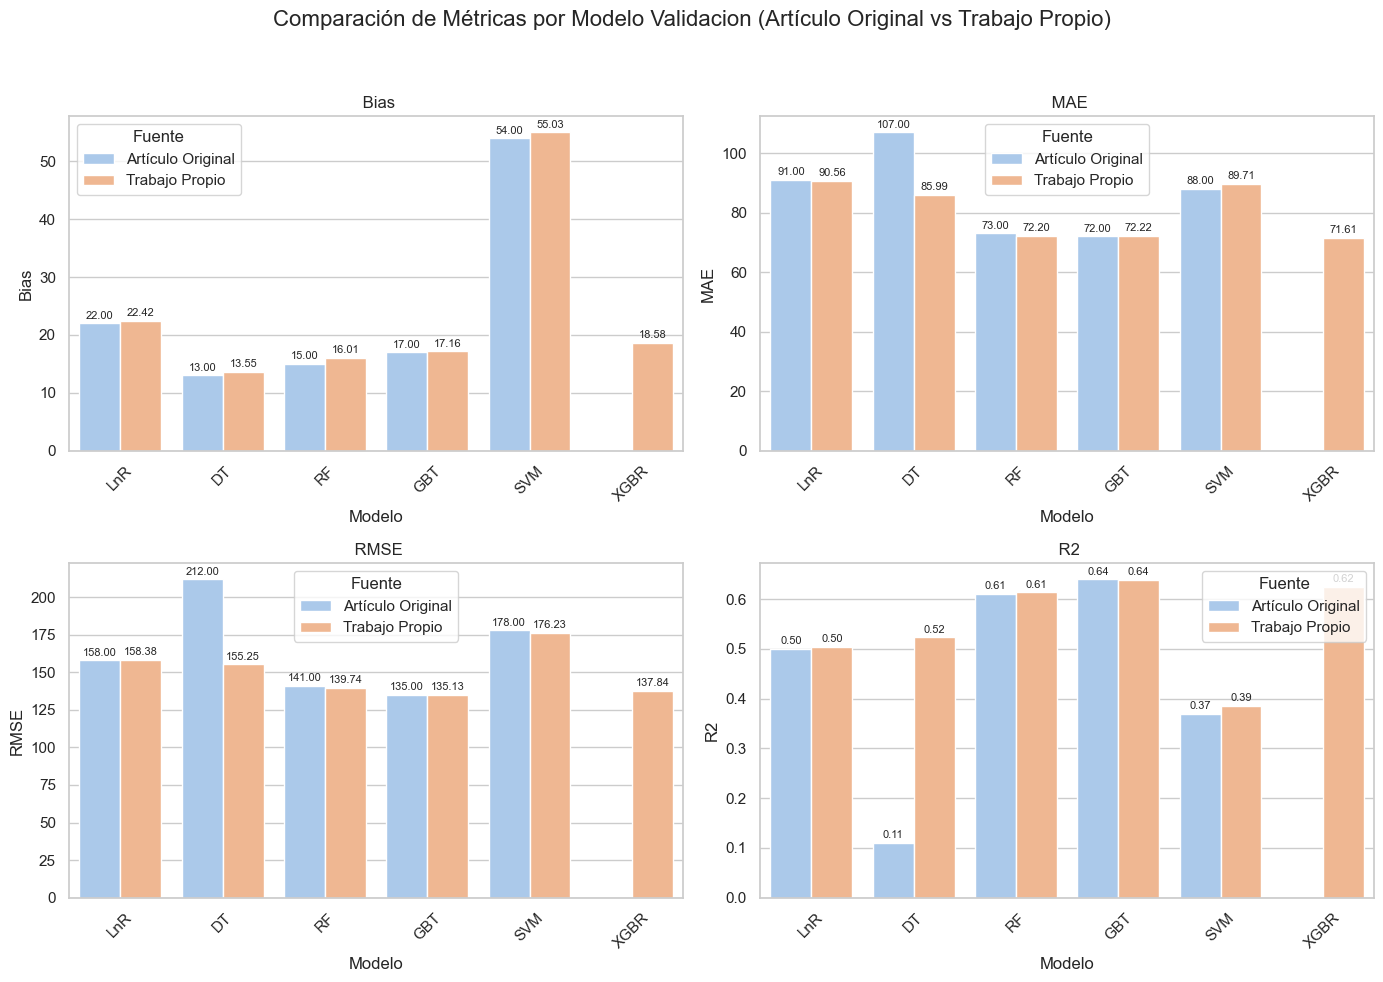

In [57]:
# Datos del artículo 
datos_paper = {
    'Modelo': ['LnR', 'DT', 'RF', 'GBT', 'SVM'],
    'Bias': [22, 13, 15, 17, 54],
    'MAE': [91, 107, 73, 72, 88],
    'RMSE': [158, 212, 141, 135, 178],
    'R2': [0.50, 0.11, 0.61, 0.64, 0.37],
    'Fuente': ['Artículo Original'] * 5
}

# Datos propios
datos_propios = {
    'Modelo': ['LnR', 'DT', 'RF', 'GBT', 'SVM', 'XGBR'],
    'Bias': [22.4182, 13.5549, 16.0120, 17.1594, 55.0315, 18.5771],
    'MAE': [90.5565, 85.9865, 72.1956, 72.2174, 89.7082, 71.6109],
    'RMSE': [158.3797, 155.2545, 139.7405, 135.1255, 176.2282, 137.8371],
    'R2': [0.5036, 0.5230, 0.6136, 0.6387, 0.3855, 0.6240],
    'Fuente': ['Trabajo Propio'] * 6
}

# Crear DataFrames
df_paper = pd.DataFrame(datos_paper)
df_trabajo = pd.DataFrame(datos_propios)

# Unir datos
df = pd.concat([df_paper, df_trabajo], ignore_index=True)

# Métricas
metricas = ['Bias', 'MAE', 'RMSE', 'R2']

# Estilo
sns.set(style='whitegrid')

# Subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Graficar
for i, metrica in enumerate(metricas):
    ax = axes[i]
    sns.barplot(data=df, x='Modelo', y=metrica, hue='Fuente', palette='pastel', ax=ax)

    # Etiquetas de barras
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=8, padding=2)

    ax.set_title(f' {metrica}', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel('Modelo')
    ax.set_ylabel(metrica)

# Ajuste general
fig.suptitle('Comparación de Métricas por Modelo Validacion (Artículo Original vs Trabajo Propio)', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


En el subconjunto de test:

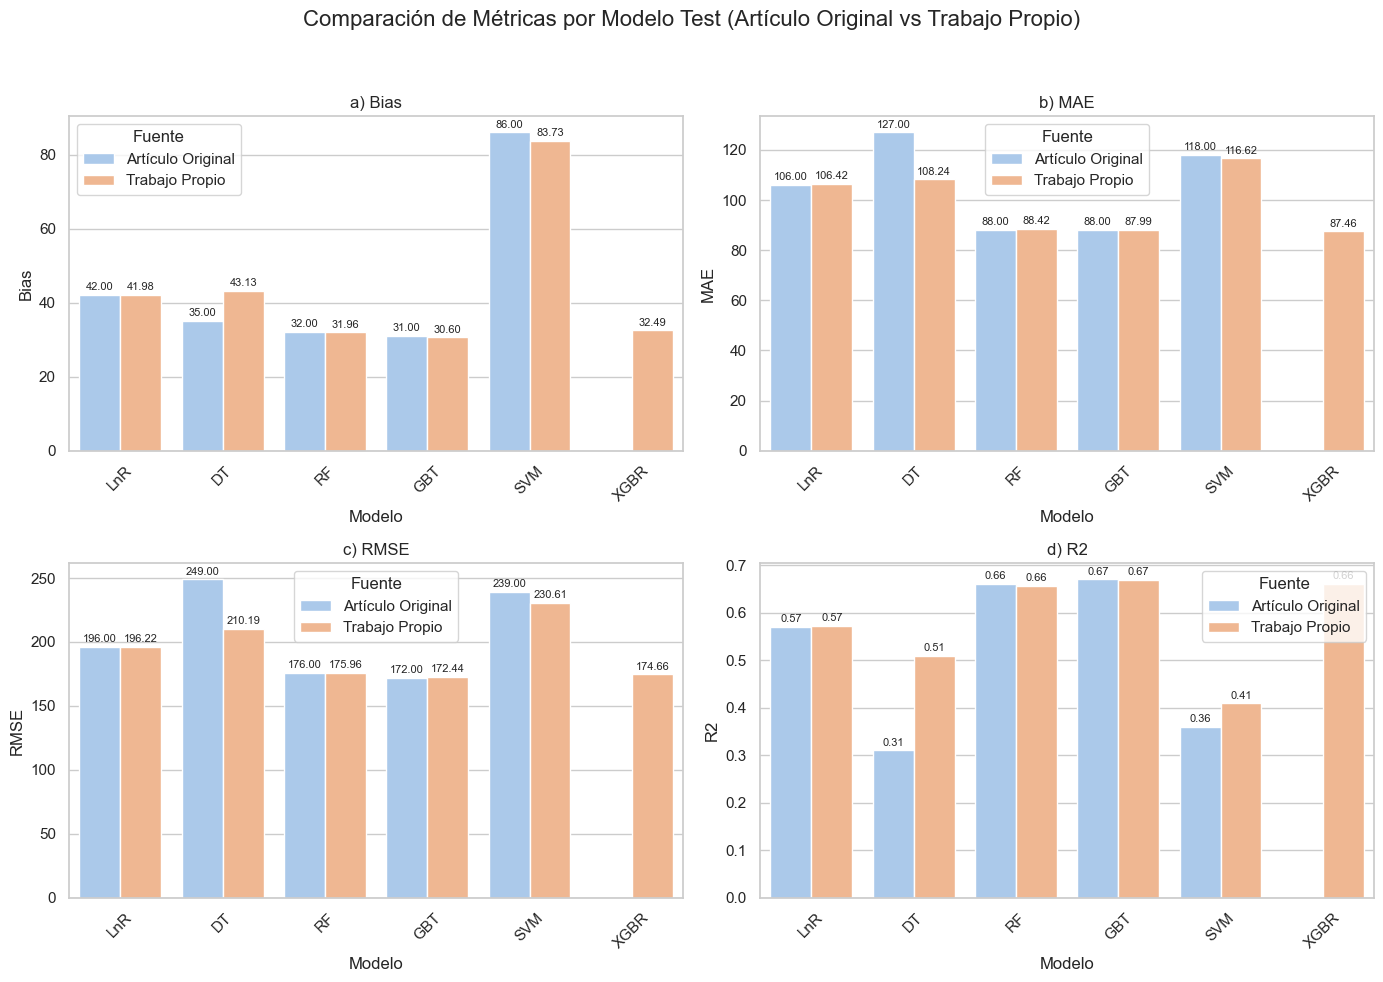

In [55]:
# Datos del artículo 
datos_paper = {
    'Modelo': ['LnR', 'DT', 'RF', 'GBT', 'SVM'],
    'Bias': [42,35,32,31,86],
    'MAE': [106,127,88,88,118],
    'RMSE': [196,249,176,172,239],
    'R2': [0.57,0.31,0.66,0.67,0.36],
    'Fuente': ['Artículo Original'] * 5
}

# Datos del trabajo propio 
datos_propios = {
    'Modelo': ['LnR', 'DT', 'RF', 'GBT', 'SVM', 'XGBR'],
    'Bias': [41.9775, 43.1277, 31.9617, 30.6021, 83.7312, 32.4927],
    'MAE': [106.4204, 108.2352, 88.4179, 87.9943, 116.6194, 87.4632],
    'RMSE': [196.2177, 210.1866, 175.9600, 172.4364, 230.6076, 174.6588],
    'R2': [0.5719, 0.5087, 0.6557, 0.6693, 0.4086, 0.6608],
    'Fuente': ['Trabajo Propio'] * 6
}

# Crear DataFrames
df_paper = pd.DataFrame(datos_paper)
df_trabajo = pd.DataFrame(datos_propios)

# Unir datos
df = pd.concat([df_paper, df_trabajo], ignore_index=True)

# Métricas y etiquetas
metricas = ['Bias', 'MAE', 'RMSE', 'R2']
etiquetas = ['a)', 'b)', 'c)', 'd)']

# Estilo
sns.set(style='whitegrid')

# Subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Gráficos
for i, metrica in enumerate(metricas):
    ax = axes[i]
    sns.barplot(data=df, x='Modelo', y=metrica, hue='Fuente', palette='pastel', ax=ax)

    # Etiquetas
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=8, padding=2)

    ax.set_title(f'{etiquetas[i]} {metrica}', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel('Modelo')
    ax.set_ylabel(metrica)

# Título global
fig.suptitle('Comparación de Métricas por Modelo Test (Artículo Original vs Trabajo Propio)', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Guardar modelo:

In [24]:
(X_train,y_train),(X_validate,y_validate),(X_test,y_test) = load_n_combine_df(date = '2019-06-01',features_to_keep=np.arange(0,36,1),class_labels=False,dropzeros=True)


In [25]:
model = xgb.XGBRegressor(booster='gbtree', max_depth=5, learning_rate=0.1, n_estimators=100)

In [26]:
model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Aseguremos que el modelo da el mismo error:

In [32]:
yhat = model.predict(X_validate)
    
mae = mean_absolute_error(y_validate,yhat)
rmse = abs(np.sqrt(mean_squared_error(y_validate,yhat)))
bias = abs(np.mean(yhat - y_validate))
r2 = r2_score(y_validate,yhat)

print(f"Method: {type(model).__name__} | R2: {r2:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | Bias: {bias:.4f}")

Method: XGBRegressor | R2: 0.6240 | MAE: 71.6109 | RMSE: 137.8371 | Bias: 18.5771


Da lo mismos resultados previos, así que se guarda usando la libreria joblib.

In [38]:
joblib.dump(model, 'modelo_xgboost_reg.pkl')

['modelo_xgboost_reg.pkl']

Ejecutemoslo para ver que se ha guardado correctamente

In [43]:
modelo = joblib.load('modelo_xgboost_reg.pkl')

In [45]:
yhat = model.predict(X_validate)
    
mae = mean_absolute_error(y_validate,yhat)
rmse = abs(np.sqrt(mean_squared_error(y_validate,yhat)))
bias = abs(np.mean(yhat - y_validate))
r2 = r2_score(y_validate,yhat)

print(f"Method: {type(model).__name__} | R2: {r2:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | Bias: {bias:.4f}")

Method: XGBRegressor | R2: 0.6240 | MAE: 71.6109 | RMSE: 137.8371 | Bias: 18.5771


Es el mismo de antes, así que se ha guardado correctamente.

## Obtener datos para Gradio

In [3]:
(X_train,y_train),(X_validate,y_validate),(X_test,y_test) = load_n_combine_df(date = '2019-06-01',features_to_keep=np.arange(0,36,1),class_labels=False,dropzeros=True)

In [5]:
X_validate.shape

(46065, 36)

In [7]:
y_validate.shape

(46065,)

Creamos tres muestras cualesquiera

In [9]:
X_validate[[500,30000,40000,15000,7500,25000,11333,38680,18465,831],:].shape

(10, 36)

Veamos las salidas de los datos de entrada

In [11]:
y_validate[[500,30000,40000,15000,7500,25000,11333,38680,18465,831]]

array([ 44, 663,  15, 354,   8, 108, 178, 152,  34,  88])

In [13]:
entradas = X_validate[[500,30000,40000,15000,7500,25000,11333,38680,18465,831],:]
salidas = y_validate[[500,30000,40000,15000,7500,25000,11333,38680,18465,831]]

Se crea el csv de los datos de entrada

In [19]:
pd.DataFrame(entradas).to_csv("entradas_reg10.csv", index=False, header=False)

In [ ]:
pd.DataFrame(salidas).to_csv("salidas_reg10.csv", index=False, header=False)